<a href="https://colab.research.google.com/github/SuminBae97/PytorchStudy/blob/main/gluonts_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install mxnet


In [ ]:
# pip install --upgrade mxnet~=1.7 gluonts

In [ ]:
# pip install d2l

In [ ]:
# pip install -U d2l
# pip install -U matplotlib

In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

Datasets

In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [4]:
print(f"available datasets:{list(dataset_recipes.keys())}")

available datasets:['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [5]:
dataset = get_dataset("m4_hourly",regenerate=True)

saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


In [6]:
dataset.train

In [15]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
entry2 = next(iter(dataset.test))
test_series = to_pandas(entry2)

In [17]:
train_series.shape , test_series.shape

((700,), (748,))

In [18]:
train_series

1750-01-01 00:00:00    605.0
1750-01-01 01:00:00    586.0
1750-01-01 02:00:00    586.0
1750-01-01 03:00:00    559.0
1750-01-01 04:00:00    511.0
                       ...  
1750-01-29 23:00:00    790.0
1750-01-30 00:00:00    784.0
1750-01-30 01:00:00    752.0
1750-01-30 02:00:00    739.0
1750-01-30 03:00:00    684.0
Freq: H, Length: 700, dtype: float32

In [16]:
test_series

1750-01-01 00:00:00    605.0
1750-01-01 01:00:00    586.0
1750-01-01 02:00:00    586.0
1750-01-01 03:00:00    559.0
1750-01-01 04:00:00    511.0
                       ...  
1750-01-31 23:00:00    785.0
1750-02-01 00:00:00    756.0
1750-02-01 01:00:00    719.0
1750-02-01 02:00:00    703.0
1750-02-01 03:00:00    659.0
Freq: H, Length: 748, dtype: float32

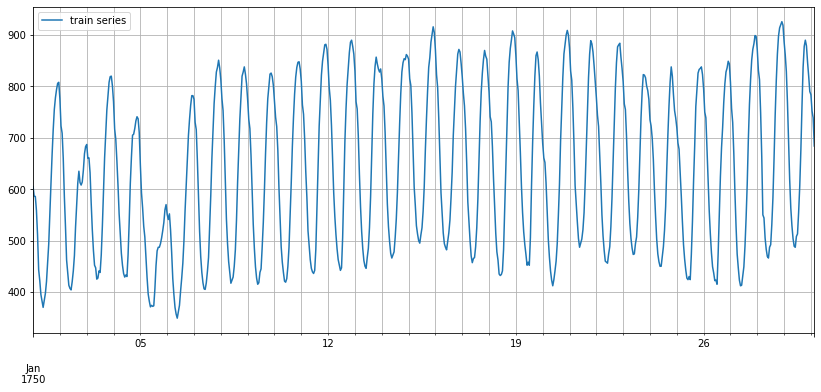

In [14]:
plt.figure(figsize=(14,6))
train_series.plot()
plt.grid(which='both')
plt.legend(["train series"],loc='upper left')
plt.show()

In [19]:
train_series.index[-1]

Timestamp('1750-01-30 03:00:00', freq='H')

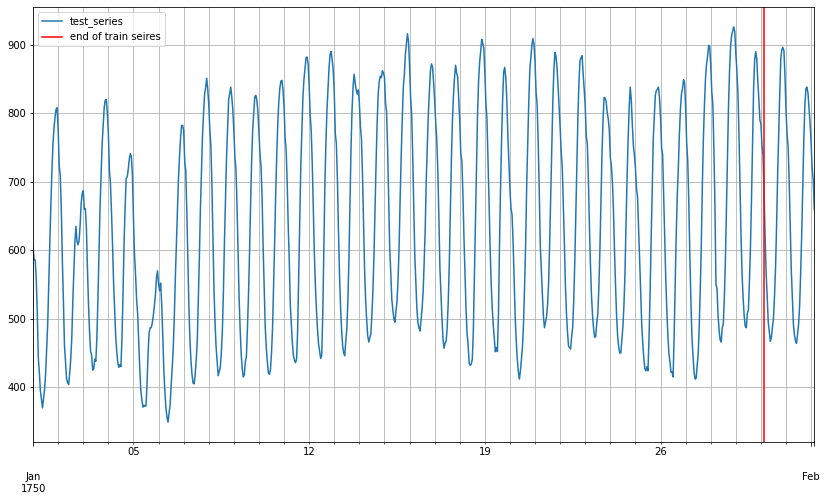

In [21]:
plt.figure(figsize=(14,8))
test_series.plot()
plt.axvline(train_series.index[-1],color='r')
plt.grid(which='both')
plt.legend(['test_series','end of train seires'])


In [24]:
train_series.index[0]

Timestamp('1750-01-01 00:00:00', freq='H')

In [ ]:
# from gluonts.dataset.common import ListDataset
# training_data = ListDataset(
#     [{"start": df.index[0], "target": df.value[:"2015-04-05 00:00:00"]}],
#     freq = "5min"
# )

In [27]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq=freq)

In [31]:
custom_dataset.shape

(10, 100)

In [32]:
start

Timestamp('2019-01-01 00:00:00', freq='H')

In [ ]:
for i in range(len(custom_dataset)):
    plt.figure(figsize=(10,5))
    plt.plot(custom_dataset[i])

In [26]:
from gluonts.dataset.common import ListDataset

In [38]:
dataset.train

In [39]:

from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer
from gluonts.model.deepar import DeepAREstimator

In [ ]:
# estimator = DeepAREstimator(freq="5min", prediction_length=12, trainer=Trainer(epochs=10))
# predictor = estimator.train(training_data=training_data)

In [47]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    #48개 length 예측
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    #freq : 1h
    freq = dataset.metadata.freq,
    trainer = Trainer(
        ctx='cpu',
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )

)

dataset.metadata.prediction_length

In [48]:
predictor = estimator.train(dataset.train)

100%|██████████| 100/100 [00:01<00:00, 64.09it/s, epoch=5/5, avg_epoch_loss=4.65]


In [49]:
from gluonts.evaluation import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)


In [50]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [106]:
ts_entry = tss[0]
dataset_test_entry = next(iter(dataset.test))

In [107]:
dataset_test_entry['target'][-1]

659.0

In [120]:
d = list(dataset.train)

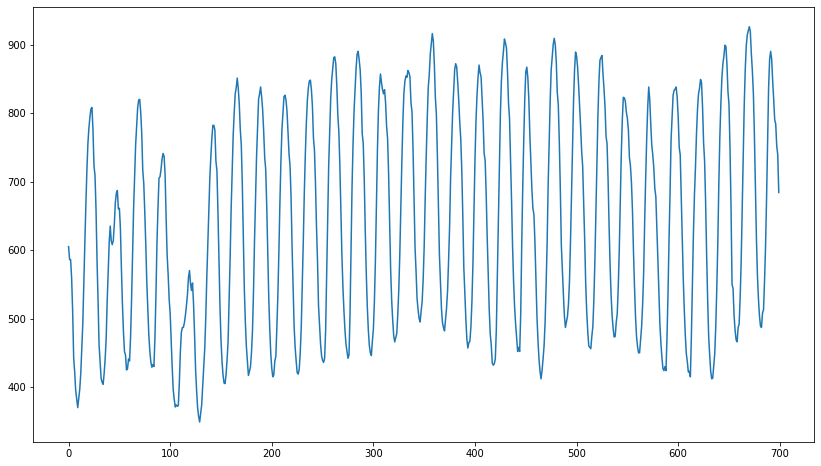

In [127]:
plt.figure(figsize=(14,8))
plt.plot(d[0]['target'])


In [135]:
forecasts[0]

gluonts.model.forecast.SampleForecast(freq="H", info=None, item_id="0", samples=numpy.array([[679.871826171875, 591.6030883789062, 488.9707946777344, 471.7033386230469, 525.9138793945312, 351.26104736328125, 538.8609008789062, 425.0525817871094, 710.810791015625, 527.5161743164062, 599.94677734375, 607.3158569335938, 801.4985961914062, 845.1469116210938, 791.6724243164062, 694.1409301757812, 834.0527954101562, 851.4693603515625, 781.2889404296875, 974.5986938476562, 907.1983642578125, 767.6365356445312, 761.0271606445312, 714.8161010742188, 620.5877685546875, 461.7248840332031, 509.1719665527344, 611.065185546875, 363.36529541015625, 205.637451171875, 939.4281616210938, 520.7623901367188, 484.3686218261719, 463.4801330566406, 617.5853271484375, 695.292724609375, 695.8380737304688, 864.1693115234375, 954.1510620117188, 951.2971801757812, 564.74169921875, 844.5064697265625, 836.154541015625, 884.0872192382812, 1095.29345703125, 940.7594604492188, 842.077880859375, 680.9659423828125], [-4

In [165]:
prediction = forecasts[0].mean


In [169]:
y = tss[0][700:748].to_numpy().reshape(-1)

In [170]:
y

array([619., 565., 532., 495., 481., 467., 473., 488., 501., 534., 576.,
       639., 712., 772., 830., 880., 893., 896., 891., 854., 803., 769.,
       751., 701., 635., 572., 532., 493., 477., 468., 464., 477., 492.,
       519., 568., 624., 696., 761., 812., 836., 838., 829., 807., 785.,
       756., 719., 703., 659.], dtype=float32)

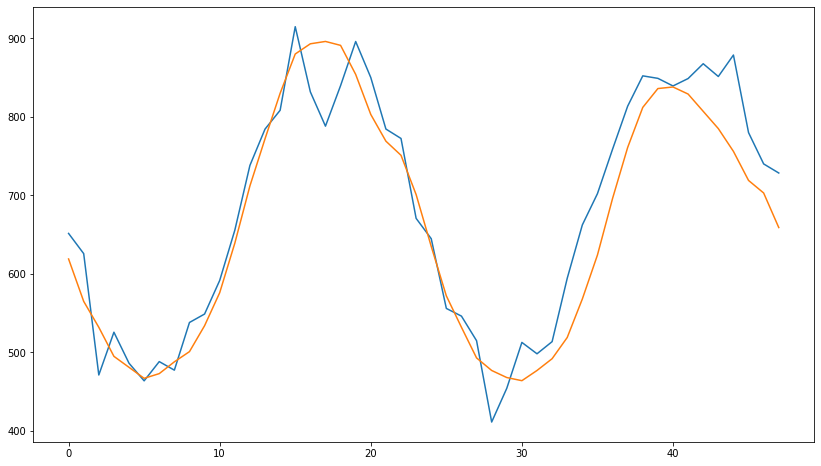

In [171]:
plt.figure(figsize=(14,8))
plt.plot(prediction)
plt.plot(y)